In [ ]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split #, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read csv files in data
train = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test= pd.read_csv('/content/drive/MyDrive/data/test.csv')

In [ ]:
train

,full_sq,life_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43.0,27.0,4.0,Investment,Bibirevo,6.407578e+06,155572.0,0.189727,0.000070,9576.0,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,34.0,19.0,3.0,Investment,Nagatinskij Zaton,9.589337e+06,115352.0,0.372602,0.049637,6880.0,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,43.0,29.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708.0,0.112560,0.118537,5879.0,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,77.0,77.0,4.0,Investment,Basmannoe,8.398461e+06,108171.0,0.015234,0.037316,5706.0,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0
4,67.0,46.0,14.0,Investment,Nizhegorodskoe,7.506452e+06,43795.0,0.007670,0.486246,2418.0,...,62.0,14.0,1.0,53.0,78.0,1.0,20.0,113.0,17.0,9100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181502,48.0,33.0,3.0,Investment,Poselenie Mihajlovo-Jarcevskoe,6.455617e+07,4949.0,0.586175,0.005819,346.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3480000.0
181503,48.0,33.0,3.0,Investment,Poselenie Mihajlovo-Jarcevskoe,6.455617e+07,4949.0,0.586175,0.005819,346.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3480000.0
181504,48.0,33.0,3.0,Investment,Poselenie Mihajlovo-Jarcevskoe,6.455617e+07,4949.0,0.586175,0.005819,346.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3480000.0
181505,48.0,33.0,3.0,Investment,Poselenie Mihajlovo-Jarcevskoe,6.455617e+07,4949.0,0.586175,0.005819,346.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3480000.0


In [ ]:
#  Import the necessary libraries
#convert data types where coluhmns have values yes and no to 1 and 0
train = train.replace({'yes': 1, 'no': 0})
test = test.replace({'yes': 1, 'no': 0})
from sklearn.preprocessing import LabelEncoder

#Create an instance of LabelEncoder
lbl = LabelEncoder()

#Fit the label encoder on the combined data of train and test datasets
lbl.fit(list(train['ecology'].values) + list(test['ecology'].values))

#Convert the 'ecology' column in the train dataset
train['ecology'] = lbl.transform(list(train['ecology'].values))

#Convert the 'ecology' column in the test dataset
test['ecology'] = lbl.transform(list(test['ecology'].values))
#do label encoding for prodcut type as well
lbl.fit(list(train['product_type'].values) + list(test['product_type'].values))
train['product_type'] = lbl.transform(list(train['product_type'].values))
test['product_type'] = lbl.transform(list(test['product_type'].values))
train.drop(columns=['sub_area'], inplace=True)
test.drop(columns=['sub_area'], inplace=True)


In [ ]:
X = train.drop(columns=['price_doc'])
y = train[['price_doc']]

In [ ]:
#save row id in a dataframe
row_id = test['row ID']
#drop it from test now
test = test.drop(columns=['row ID'])

In [ ]:
import statsmodels.api as sm

# Add a constant column to the feature matrix
XSM = sm.add_constant(train.drop(columns=['price_doc']))

# Fit the ordinary least squares (OLS) model
model = sm.OLS(train['price_doc'], XSM).fit()

# Get the p-values of all columns
p_values = model.pvalues

# Sort the p-values in ascending order
sorted_p_values = p_values.sort_values()

# Show only the bottom 35 columns with the lowest p-values
bottom_35_p_values = sorted_p_values[:30]

# Print the bottom 35 p-values
# print(bottom_35_p_values)
# Use the bottom 35 features above to train the model
if 'const' in bottom_35_p_values:
    bottom_35_p_values = bottom_35_p_values.drop('const')
# Select the bottom 35 variables from the dataset
Xp = train[list(bottom_35_p_values.index)]
# Do the same for the test dataset as well
testp = test[list(bottom_35_p_values.index)]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA on the training data
pca = PCA()
pca.fit(train.drop(columns=['price_doc']))

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()


ValueError: ignored

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the training data
pca = PCA(n_components=10)
Xp = pca.fit_transform(train.drop(columns=['price_doc']))

# Transform the test data using the same PCA model
testp = pca.transform(test)


In [ ]:
Xp=Xp.astype('float64')
testp=testp.astype('float64')

In [ ]:
#scaled X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xp)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.3, random_state=2)
t_scaled=scaler.fit_transform(testp)

In [ ]:
import torch
import os
os.environ["KERAS_BACKEND"] = "torch"
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop,Adam

In [ ]:
from keras import regularizers


In [ ]:
X_scaled.shape

(181507, 10)

In [ ]:
#GIVING 0 LOSS
from keras.callbacks import EarlyStopping
# get the number of input features in X and assign to n_features
n_features = trainX.shape[1]
# Create a Sequential model
model = Sequential()
# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.add(Dense(128, input_dim=n_features, activation='relu',kernel_regularizer=regularizers.l2(0.01)))

# The Hidden Layers with regularization and early stopping:
# model.add(Dense(128, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='normal',activation='linear', kernel_regularizer=regularizers.l2(0.01)))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

print(model.summary())
model.fit(X_scaled, y, epochs=150, batch_size=64)
print('eval')

# Fit the model with early stopping
# model.fit(trainX, trainy, epochs=50, batch_size=2048, validation_data=(X_scaled, t_scaled), callbacks=[early_stopping])


In [ ]:
# get the number of input features in X and assign to n_features
n_features = trainX.shape[1]
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Create a Sequential model
model = Sequential()

# Add the first hidden layer with 10 neurons and specify the input shape
model.add(Dense(128, input_dim=n_features, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
# Add the second hidden layer with 5 neurons
# model.add(Dense(270, activation='relu'))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(245, activation='relu'))
# model.add(Dense(135, activation='relu'))

# The Hidden Layers with regularization:
# model.add(Dense(100, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.1))
# Add the output layer with 1 neuron (for regression) and 'linear' activation
# model.add(Dense(1, activation='linear'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer='adam', loss=root_mean_squared_error)

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC']) #change optimizer

# Print the model summary
print(model.summary())
model.fit(X_scaled, y, epochs=200, batch_size=64, callbacks=[early_stopping])
print('eval')

# model.evaluate(testX, testy, batch_size=4096)

In [ ]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# FILEPATH: /c:/Users/hamza/OneDrive/Documents/7th Sem/IDM/Challenge2/NN.ipynb
# get the number of input features in X and assign to n_features
n_features = trainX.shape[1]
# Create a Sequential model
model = Sequential()

# Add the first hidden layer with 10 neurons and specify the input shape
model.add(Dense(128, input_dim=n_features, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
# Add the second hidden layer with 5 neurons
# model.add(Dense(270, activation='relu'))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(245, activation='relu'))
# model.add(Dense(135, activation='relu'))

# The Hidden Layers with regularization:
# model.add(Dense(128, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.1))
# Add the output layer with 1 neuron (for regression) and 'linear' activation
# model.add(Dense(1, activation='linear'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer='adam', loss=root_mean_squared_error)

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC']) #change optimizer

# Print the model summary
print(model.summary())

# Fit the model with early stopping
model.fit(X_scaled, y, epochs=50, batch_size=2048, validation_split=0.3, callbacks=[early_stopping])
print('eval')

# model.evaluate(testX, testy, batch_size=4096)

In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns


In [ ]:
categorical_features

Index(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [ ]:
3# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Extract features and target variable from the training data
X = train.drop(columns=['price_doc'])  # Features
y = train['price_doc']  # Target variable

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [ ]:
full = preprocessor.fit_transform(X)

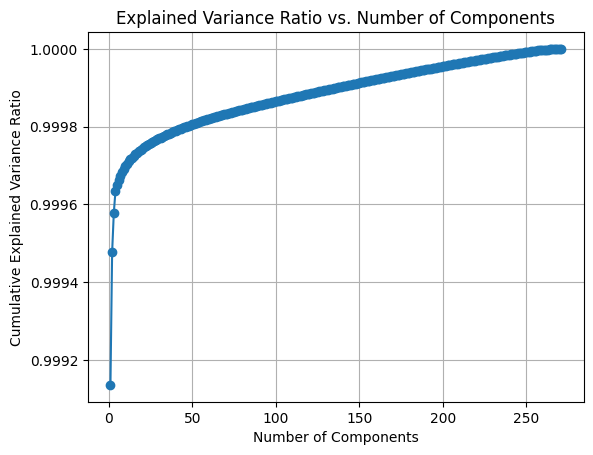

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Perform PCA on the training data
pca = PCA()
pca.fit(full)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the training data
pca = PCA(n_components=12)
Xp = pca.fit_transform(full)

# Transform the test data using the same PCA model
# testp = pca.transform(test)


In [ ]:
test_full = preprocessor.fit_transform(test)

In [ ]:
X_test_preprocessed = pca.fit_transform(test_full)


In [ ]:
# Get the configuration of the model
config = model.get_config()

# Print the configuration
print(config)


{'name': 'sequential_12', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 12), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_13'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_46', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 12)}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 

Epoch 1/20
5659/5673 [============================>.] - ETA: 0s - loss: 678654895980544.0000

5673/5673 [==============================] - 14s 2ms/step - loss: 678352302112768.0000
Epoch 2/20
5666/5673 [============================>.] - ETA: 0s - loss: 551318343122944.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 551339515969536.0000
Epoch 3/20
5670/5673 [============================>.] - ETA: 0s - loss: 335126064005120.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 335111803371520.0000
Epoch 4/20
5664/5673 [============================>.] - ETA: 0s - loss: 211407433891840.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 211344619995136.0000
Epoch 5/20
5660/5673 [============================>.] - ETA: 0s - loss: 197219831513088.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 197187166273536.0000
Epoch 6/20
5659/5673 [============================>.] - ETA: 0s - loss: 195761891442688.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 195780296048640.0000
Epoch 7/20
5651/5673 [============================>.] - ETA: 0s - loss: 192730533724160.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 192619284004864.0000
Epoch 8/20
5656/5673 [============================>.] - ETA: 0s - loss: 194044357509120.0000

5673/5673 [==============================] - 14s 2ms/step - loss: 194079539331072.0000
Epoch 9/20
5659/5673 [============================>.] - ETA: 0s - loss: 191842599567360.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 191869745102848.0000
Epoch 10/20
5653/5673 [============================>.] - ETA: 0s - loss: 191547102461952.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 191588777066496.0000
Epoch 11/20
5664/5673 [============================>.] - ETA: 0s - loss: 191667579650048.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 191647849644032.0000
Epoch 12/20
5667/5673 [============================>.] - ETA: 0s - loss: 191269942853632.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 191267812147200.0000
Epoch 13/20
5663/5673 [============================>.] - ETA: 0s - loss: 190575550660608.0000

5673/5673 [==============================] - 12s 2ms/step - loss: 190532282220544.0000
Epoch 14/20
5654/5673 [============================>.] - ETA: 0s - loss: 189626631323648.0000

5673/5673 [==============================] - 12s 2ms/step - loss: 189571216179200.0000
Epoch 15/20
5661/5673 [============================>.] - ETA: 0s - loss: 190055775731712.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 190152026619904.0000
Epoch 16/20
5660/5673 [============================>.] - ETA: 0s - loss: 189304592662528.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 189286926254080.0000
Epoch 17/20
5657/5673 [============================>.] - ETA: 0s - loss: 188617414672384.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 188787434979328.0000
Epoch 18/20
5646/5673 [============================>.] - ETA: 0s - loss: 187958103638016.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 188006019366912.0000
Epoch 19/20
5654/5673 [============================>.] - ETA: 0s - loss: 189425774493696.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 189476039032832.0000
Epoch 20/20
5656/5673 [============================>.] - ETA: 0s - loss: 188201440378880.0000

5673/5673 [==============================] - 13s 2ms/step - loss: 188262358450176.0000


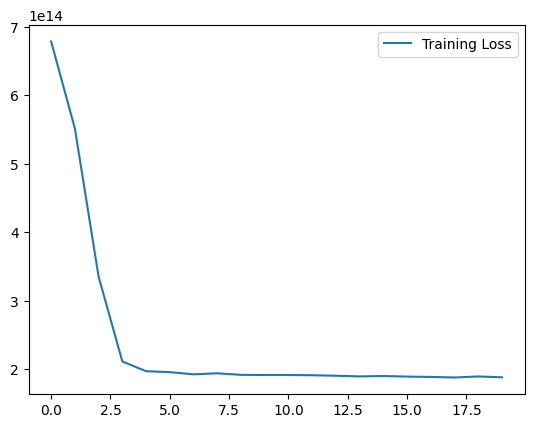

2431/2431 [==============================] - 3s 1ms/step
Number of Features Used: 271


In [ ]:
# Define the neural network model with enhancements
#REGULIAZTION OFF
model = keras.Sequential([
    layers.Input(shape=(full.shape[1],)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    layers.BatchNormalization(),  # Batch Normalization layer
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(64, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dense(1)  # Output layer with 1 unit (regression problem)
])

# Compile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss='mean_squared_error')

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the neural network model with enhancements
history = model.fit(full, y, epochs=20, batch_size=32,
                    callbacks=[early_stopping])

# Plot training history (optional)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Make predictions on the validation set
# X_valid_preprocessed = preprocessor.transform(X_valid)
# y_pred = model.predict(X_valid_preprocessed)

# Evaluate the model
# mse = mean_squared_error(y_valid, y_pred)
# print(f'Mean Squared Error on Validation Set: {mse}')

# Now, make predictions on the test set
X_test_preprocessed = preprocessor.transform(test)
price_doc = model.predict(X_test_preprocessed)


# Print the number of features used after preprocessing
num_features_used = X_train_preprocessed.shape[1]
print(f'Number of Features Used: {num_features_used}')

In [ ]:
model

NameError: ignored

In [ ]:
price_doc = model.predict(t_scaled)

NameError: ignored

In [ ]:
# Now, make predictions on the test set
price_doc = model.predict(X_test_preprocessed)

2431/2431 [==============================] - 7s 3ms/step


In [ ]:
price_doc

array([[8107286.5],
       [9764605. ],
       [6606724. ],
       ...,
       [4122104.5],
       [4122104.5],
       [4122104.5]], dtype=float32)

In [ ]:
#Create a DataFrame for the predictions
predictions_df = pd.DataFrame(price_doc, columns=['price_doc'])

#Add the record ID from the test data to the predictions DataFrame
predictions_df.insert(0, 'row ID', row_id)

#Save the predictions to a CSV file
predictions_df.to_csv('downloadme.csv', index=False)

NameError: ignored

In [ ]:
price_doc.shape

(77789, 1)